## Sensitivity of the parameters during EoH and EoR redshifts.

Copy the zarr store to the local gpu node

In [1]:
%%time
!cp -r /data/p303146/Projects/Inference21cm/Astro_6/fixSeed/s21cm_Astro_6.zarr* /local/tmp/

CPU times: user 2.57 s, sys: 820 ms, total: 3.39 s
Wall time: 4min 22s


Importing dependencies

In [28]:
!rm -r ./02_output/
!mkdir ./02_output

In [29]:
import numpy as np
np.random.seed(50);

from scipy import stats
import torch
torch.manual_seed(50);

import swyft as sl
import pytorch_lightning as pl
import pickle

import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "stix"
%config InlineBackend.figure_format = "svg"
%matplotlib inline

In [30]:
# Redshifts
reds_EoH = [24.359810, 20.219959, 17.111031, 14.457590, 12.456770]
reds_EoR = [10.714930, 9.402521, 8.237142, 7.202319, 6.429094]
reds = reds_EoH + reds_EoR

# Parameters: zeta, Tvir, Rmfp, Lx, E0, \alpha
labels = [r'$\zeta$', r'$T_{\rm vir}^{\rm min}$', r'$R_{\rm mfp}$',
          r'$L_X$', r'$E_0$', r'$\alpha_{X}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15, 40.5, 500, 1])

# Priors
vmin = np.array([10, 4.2, 8, 39.5, 100, -0.5])
vmax = np.array([100, 5.4, 25, 41.5, 900, 2.5])

# k-modes
k_vals = np.linspace(0.1, 0.8, 8)

# Path for mock observation and noise
noisePath = "./../Training_Data/ska_low_noise.npy"
obsPath = "./../Training_Data/mockObs.pkl"

Thermal noise level

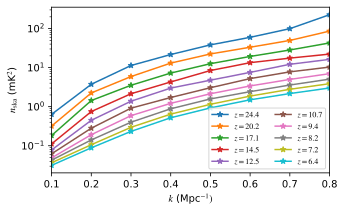

In [31]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)

fig, ax = plt.subplots(figsize=(5, 3))
for i in range(len(reds)):
    ax.plot(k_vals, instNoise[i], "*-", label=r"$z = %.1f$"%reds[i])
    ax.set_yscale("log")
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.legend(ncol=2, fontsize=8)
    ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    ax.set_ylabel(r"$n_{\rm ska}$ (mK$^2$)")

Mock Observation

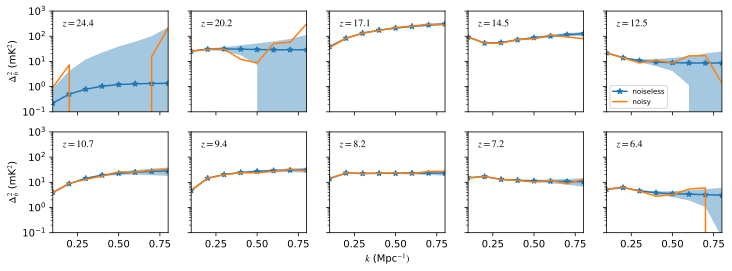

In [32]:
with open(obsPath, 'rb') as f:
    obs0 = pickle.load(f)
    
fig, ax = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)
for i, ax in enumerate(fig.axes):
    sigma = np.sqrt(instNoise[i]**2. + (obs0['pk_sv_z%.1f'%reds[i]].numpy())**2.)
    ax.plot(k_vals, obs0['pk_mu_z%.1f'%reds[i]], "*-", label="noiseless")
    ax.fill_between(k_vals, obs0['pk_mu_z%.1f'%reds[i]] - sigma,
                   obs0['pk_mu_z%.1f'%reds[i]] + sigma, alpha=0.4)
    ax.plot(k_vals, obs0['pk_z%.1f'%reds[i]], label="noisy")
    ax.set_ylim(1e-1, 1e3)
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.set_yscale("log")
    if i == 4: ax.legend(loc="lower left", fontsize=7)
    if i == 7: ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    if i == 0 or i == 5: ax.set_ylabel(r"$\Delta_{b}^2$ (mK$^2$)")
    ax.text(0.16, 2.5*1e2, r"$z=%.1f$"%reds[i], fontsize=10)

Noise model (Sample variance + Thermal noise)

In [33]:
# Use it as a hook: takes into account the instrumental noise and sample variance
def noise(out):
    for i in range(len(reds)):
        mu = out['pk_mu_z%.1f'%reds[i]]
        sv = out['pk_sv_z%.1f'%reds[i]]
        
        # Total noise including the intrumental noise and sample variance
        total_noise_val = np.sqrt(instNoise[i]**2. + sv**2.)
        n = np.float32(np.random.randn(*total_noise_val.shape))*total_noise_val
        
        out['pk_z%.1f'%reds[i]] = mu + n
    return out

Store and data loaders

In [34]:
zs = sl.ZarrStore("/local/tmp/s21cm_Astro_6.zarr")
data_loader_train = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[0, 16_000],
                                      on_after_load_sample=noise)
data_loader_val = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[16_000, 18_000],
                                    on_after_load_sample=noise)
data_loader_test = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[18_000, 20_000],
                                     on_after_load_sample=noise)

Trainer, logger and callbacks

In [35]:
logger = pl.loggers.TensorBoardLogger("/data/p303146/lightning_logs", name = "post_EoH_EoR")
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k=1)
callbacks = [
    pl.callbacks.LearningRateMonitor(),
    pl.callbacks.EarlyStopping("val_loss", patience=5),
    model_checkpoint
]

trainer = sl.SwyftTrainer(accelerator='gpu', gpus=1, max_epochs=100, logger=logger,
                          callbacks=callbacks, precision=32)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/usr/bin/srun


Network: Ratio estimator

In [36]:
class Network(sl.SwyftModule):
    def __init__(self):
        super().__init__()
        
        self.n_features = 32

        marginals = self.get_marginals(n_params=len(vtrue))
        
        self.l_EoH = torch.nn.Linear(40, self.n_features)
        self.l_EoR = torch.nn.Linear(40, self.n_features)
        
        self.logratios1_EoH = sl.LogRatioEstimator_1dim(num_features=self.n_features,
                                                        num_params=len(vtrue),
                                                        hidden_features=256,
                                                        num_blocks=3,
                                                        dropout=0.2,
                                                        varnames='z')
        self.logratios1_EoR = sl.LogRatioEstimator_1dim(num_features=self.n_features,
                                                        num_params=len(vtrue),
                                                        hidden_features=256,
                                                        num_blocks=3,
                                                        dropout=0.2,
                                                        varnames='z')
        
        self.logratios2_EoH = sl.LogRatioEstimator_Ndim(num_features=self.n_features,
                                                        marginals=marginals,
                                                        hidden_features=256,
                                                        num_blocks=3,
                                                        dropout=0.2,
                                                        varnames ='z')
        self.logratios2_EoR = sl.LogRatioEstimator_Ndim(num_features=self.n_features,
                                                        marginals=marginals,
                                                        hidden_features=256,
                                                        num_blocks=3,
                                                        dropout=0.2,
                                                        varnames ='z')        

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j>i: marginals.append((i, j))
        return tuple(marginals)
        
    def forward(self, A, B):
        x_EoH = torch.cat([A['pk_z%.1f'%zi] for zi in reds_EoH], axis=1)
        x_EoH = self.l_EoH(x_EoH)

        x_EoR = torch.cat([A['pk_z%.1f'%zi] for zi in reds_EoR], axis=1)
        x_EoR = self.l_EoR(x_EoR)
        z = B['z']

        ratios_1_EoH = self.logratios1_EoH(x_EoH, z)
        ratios_1_EoR = self.logratios1_EoR(x_EoR, z)
        
        
        ratios_2_EoH = self.logratios2_EoH(x_EoH, z)
        ratios_2_EoR = self.logratios2_EoR(x_EoR, z)        
        return ratios_1_EoH, ratios_1_EoR, ratios_2_EoH, ratios_2_EoR

In [37]:
network = Network()

Training the network

In [38]:
import os

if os.path.exists("./02_output/trainedLogRatios.pt"):
    network.load_state_dict(torch.load("./02_output/trainedLogRatios.pt"))
else:
    trainer.fit(network, data_loader_train, data_loader_val)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                   | Params
----------------------------------------------------------
0 | l_EoH          | Linear                 | 1.3 K 
1 | l_EoR          | Linear                 | 1.3 K 
2 | logratios1_EoH | LogRatioEstimator_1dim | 2.4 M 
3 | logratios1_EoR | LogRatioEstimator_1dim | 2.4 M 
4 | logratios2_EoH | LogRatioEstimator_Ndim | 6.1 M 
5 | logratios2_EoR | LogRatioEstimator_Ndim | 6.1 M 
----------------------------------------------------------
17.1 M    Trainable params
0         Non-train

/usr/bin/srun


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Save the trained network

In [39]:
torch.save(network.state_dict(), "./02_output/trainedLogRatios.pt")

Network performance on the test dataset

In [40]:
trainer.test(network, data_loader_test)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/bin/srun


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -24.430252075195312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -24.430252075195312}]

Sampling from prior

In [45]:
def uv(u):
    return u * (vmax - vmin) + vmin

prior_samples = sl.Samples(z = uv(np.random.rand(200_000, 6)).astype('f'))

Predictions

In [46]:
pred = trainer.infer(network, sl.Sample(obs0), prior_samples)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/bin/srun


Predicting: 250it [00:00, ?it/s]

Corner plot

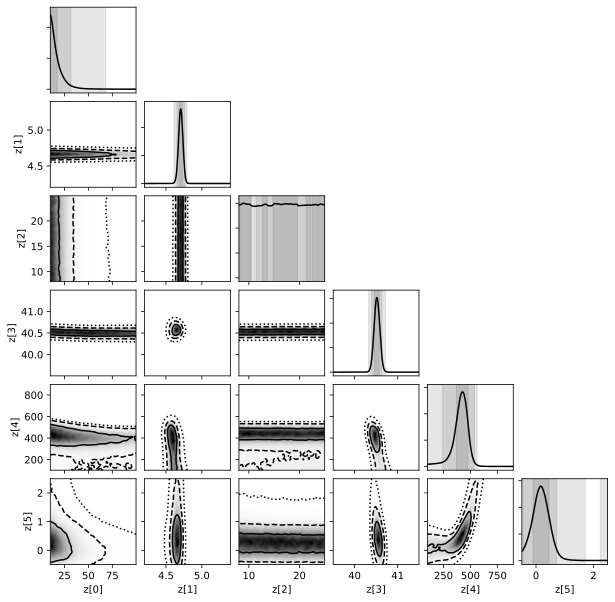

In [47]:
sl.corner([pred[0], pred[2]], ('z[0]', 'z[1]', 'z[2]', 'z[3]', 'z[4]', 'z[5]'), bins=200,
          smooth=3, truth=[30, 4.7, 15, 40.5, 500, 1]);

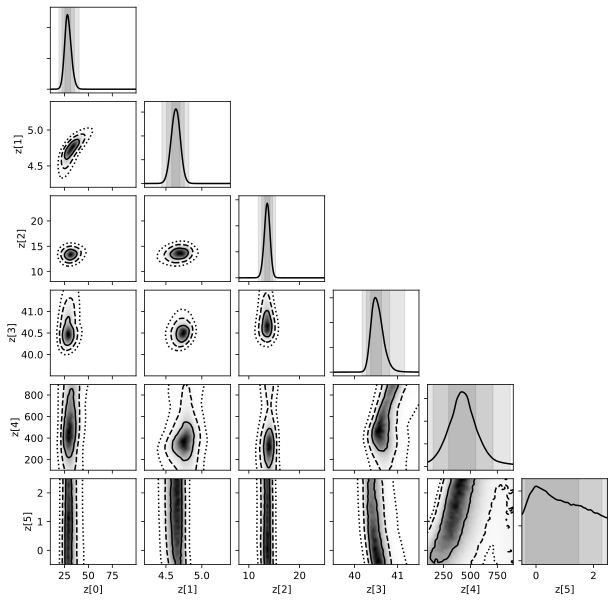

In [48]:
sl.corner([pred[1], pred[3]], ('z[0]', 'z[1]', 'z[2]', 'z[3]', 'z[4]', 'z[5]'), bins=200,
          smooth=3, truth=[30, 4.7, 15, 40.5, 500, 1]);

In [49]:
open_file = open("./02_output/logRatioSamples.pkl", "wb")
pickle.dump(pred, open_file)
open_file.close()